In [1]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import glob
%matplotlib inline

sns.set(rc={'figure.figsize':(6, 3)})
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 600
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


/home/mcopik/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [102]:
import pandas as pd
from pathlib import Path
import re

def extract_time_from_line(line):
    """Extract time value from a line matching the format 'Start: X, time: Y'"""
    match = re.search(r'Start: \d+, time: (\d+\.\d+)', line)
    if match:
        return float(match.group(1))
    return None

def extract_mig_config(filename):
    """Extract MIG configuration from filename (e.g., '1g.12gb' from '1g.12gb_isolated_output.txt')"""
    match = re.match(r'(\d+g\.\d+gb)_', filename)
    if match:
        return match.group(1)
    return None

def process_benchmark_files(base_dir):
    """Process all benchmark files and create a DataFrame with results"""
    base_path = Path(base_dir)
    results = []
    
    # Process each benchmark directory
    for bench_dir in base_path.iterdir():
        if not bench_dir.is_dir() or bench_dir.name == 'yolop':
            continue
            
        benchmark_name = bench_dir.name
        
        output_file = os.path.join(base_dir, benchmark_name,'raw_output.txt')

        with open(output_file, 'r') as f:
            timing_lines = [line for line in f if 'Start:' in line and 'time:' in line]

            # Skip the first timing value and process the rest
            for line in timing_lines[1:]:
                time_value = extract_time_from_line(line)
                if time_value is not None:
                    results.append({
                        'device': 'v100',
                        'mig_config': 'V100',
                        'benchmark': benchmark_name,
                        'time': time_value
                    })
    
    # Create DataFrame from results
    df = pd.DataFrame(results)
    return df


base_dir = "../../data/mig_size_effect/mig-isolation-bench-v100-2025-02-07T02:34:51+01:00"
df_v100 = process_benchmark_files(base_dir)

In [120]:
import pandas as pd
from pathlib import Path
import re

def extract_time_from_line(line):
    """Extract time value from a line matching the format 'Start: X, time: Y'"""
    match = re.search(r'Start: \d+, time: (\d+\.\d+)', line)
    if match:
        return float(match.group(1))
    return None

def extract_mig_config(filename):
    """Extract MIG configuration from filename (e.g., '1g.12gb' from '1g.12gb_isolated_output.txt')"""
    match = re.match(r'(\d+g\.\d+gb)_', filename)
    if match:
        return match.group(1)
    return None

def process_benchmark_files(base_dir):
    """Process all benchmark files and create a DataFrame with results"""
    base_path = Path(base_dir)
    results = []
    
    # Process each benchmark directory
    for bench_dir in base_path.iterdir():
        if not bench_dir.is_dir() or bench_dir.name == 'yolop':
            continue
            
        benchmark_name = bench_dir.name
        
        # Process each output file in the benchmark directory
        for output_file in bench_dir.glob('*g.*gb_*output.txt'):
            mig_config = extract_mig_config(output_file.name)
            if not mig_config:
                continue
                
            with open(output_file, 'r') as f:
                timing_lines = [line for line in f if 'Start:' in line and 'time:' in line]

                # Skip the first timing value and process the rest
                for line in timing_lines[1:]:
                    time_value = extract_time_from_line(line)
                    if time_value is not None:
                        results.append({
                            'device': 'h200',
                            'mig_config': mig_config,
                            'benchmark': benchmark_name,
                            'time': time_value
                        })
    
    # Create DataFrame from results
    df = pd.DataFrame(results)
    return df


base_dir = "../../data/mig_size_effect/mig-isolation-bench-h200-2025-02-07T01:11:47+01:00"
df = process_benchmark_files(base_dir)

In [121]:
df_v100

,device,mig_config,benchmark,time
0,v100,V100,resnext-101,0.051900
1,v100,V100,resnext-101,0.045579
2,v100,V100,resnext-101,0.044339
3,v100,V100,resnext-101,0.043510
4,v100,V100,resnext-101,0.044157
...,...,...,...,...
65,v100,V100,resnext-50,0.036074
66,v100,V100,resnext-50,0.035603
67,v100,V100,resnext-50,0.035569
68,v100,V100,resnext-50,0.035569


In [122]:
df = pd.concat([df, df_v100])

In [124]:
#final_df = pd.DataFrame(data=data,columns=['migsize', 'time', 'benchmark'])
#final_df
#final_df = pd.concat(dfs)
#final_df['time'] /= 1000.0
df['benchmark'] = df['benchmark'].map({
    'resnet-50': 'ResNet-50',
    'resnet-18': 'ResNet-18',
    'resnext-50': 'ResNeXt-50',
    'resnext-101': 'ResNeXt-101',
    'vgg19': 'VGG-19',
    'alexnet': 'AlexNet',
    'BERT-SQuAD': 'BERT-SQuAD'
})
df['migsize'] = df['mig_config'].map({
    'V100': 'V100',
    '1g.12gb': '1g, 12GB',
    '1g.24gb': '1g, 24GB',
    '2g.24gb': '2g',
    '3g.48gb': '3g',
    '4g.48gb': '4g',
    '7g.96gb': '7g'
})
#final_df['size'] /= 1024.0

In [125]:
df['time'] *= 1000

/tmp/ipykernel_1081704/1907231848.py:18: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  g = sns.barplot(x='benchmark', y='time', hue='migsize',


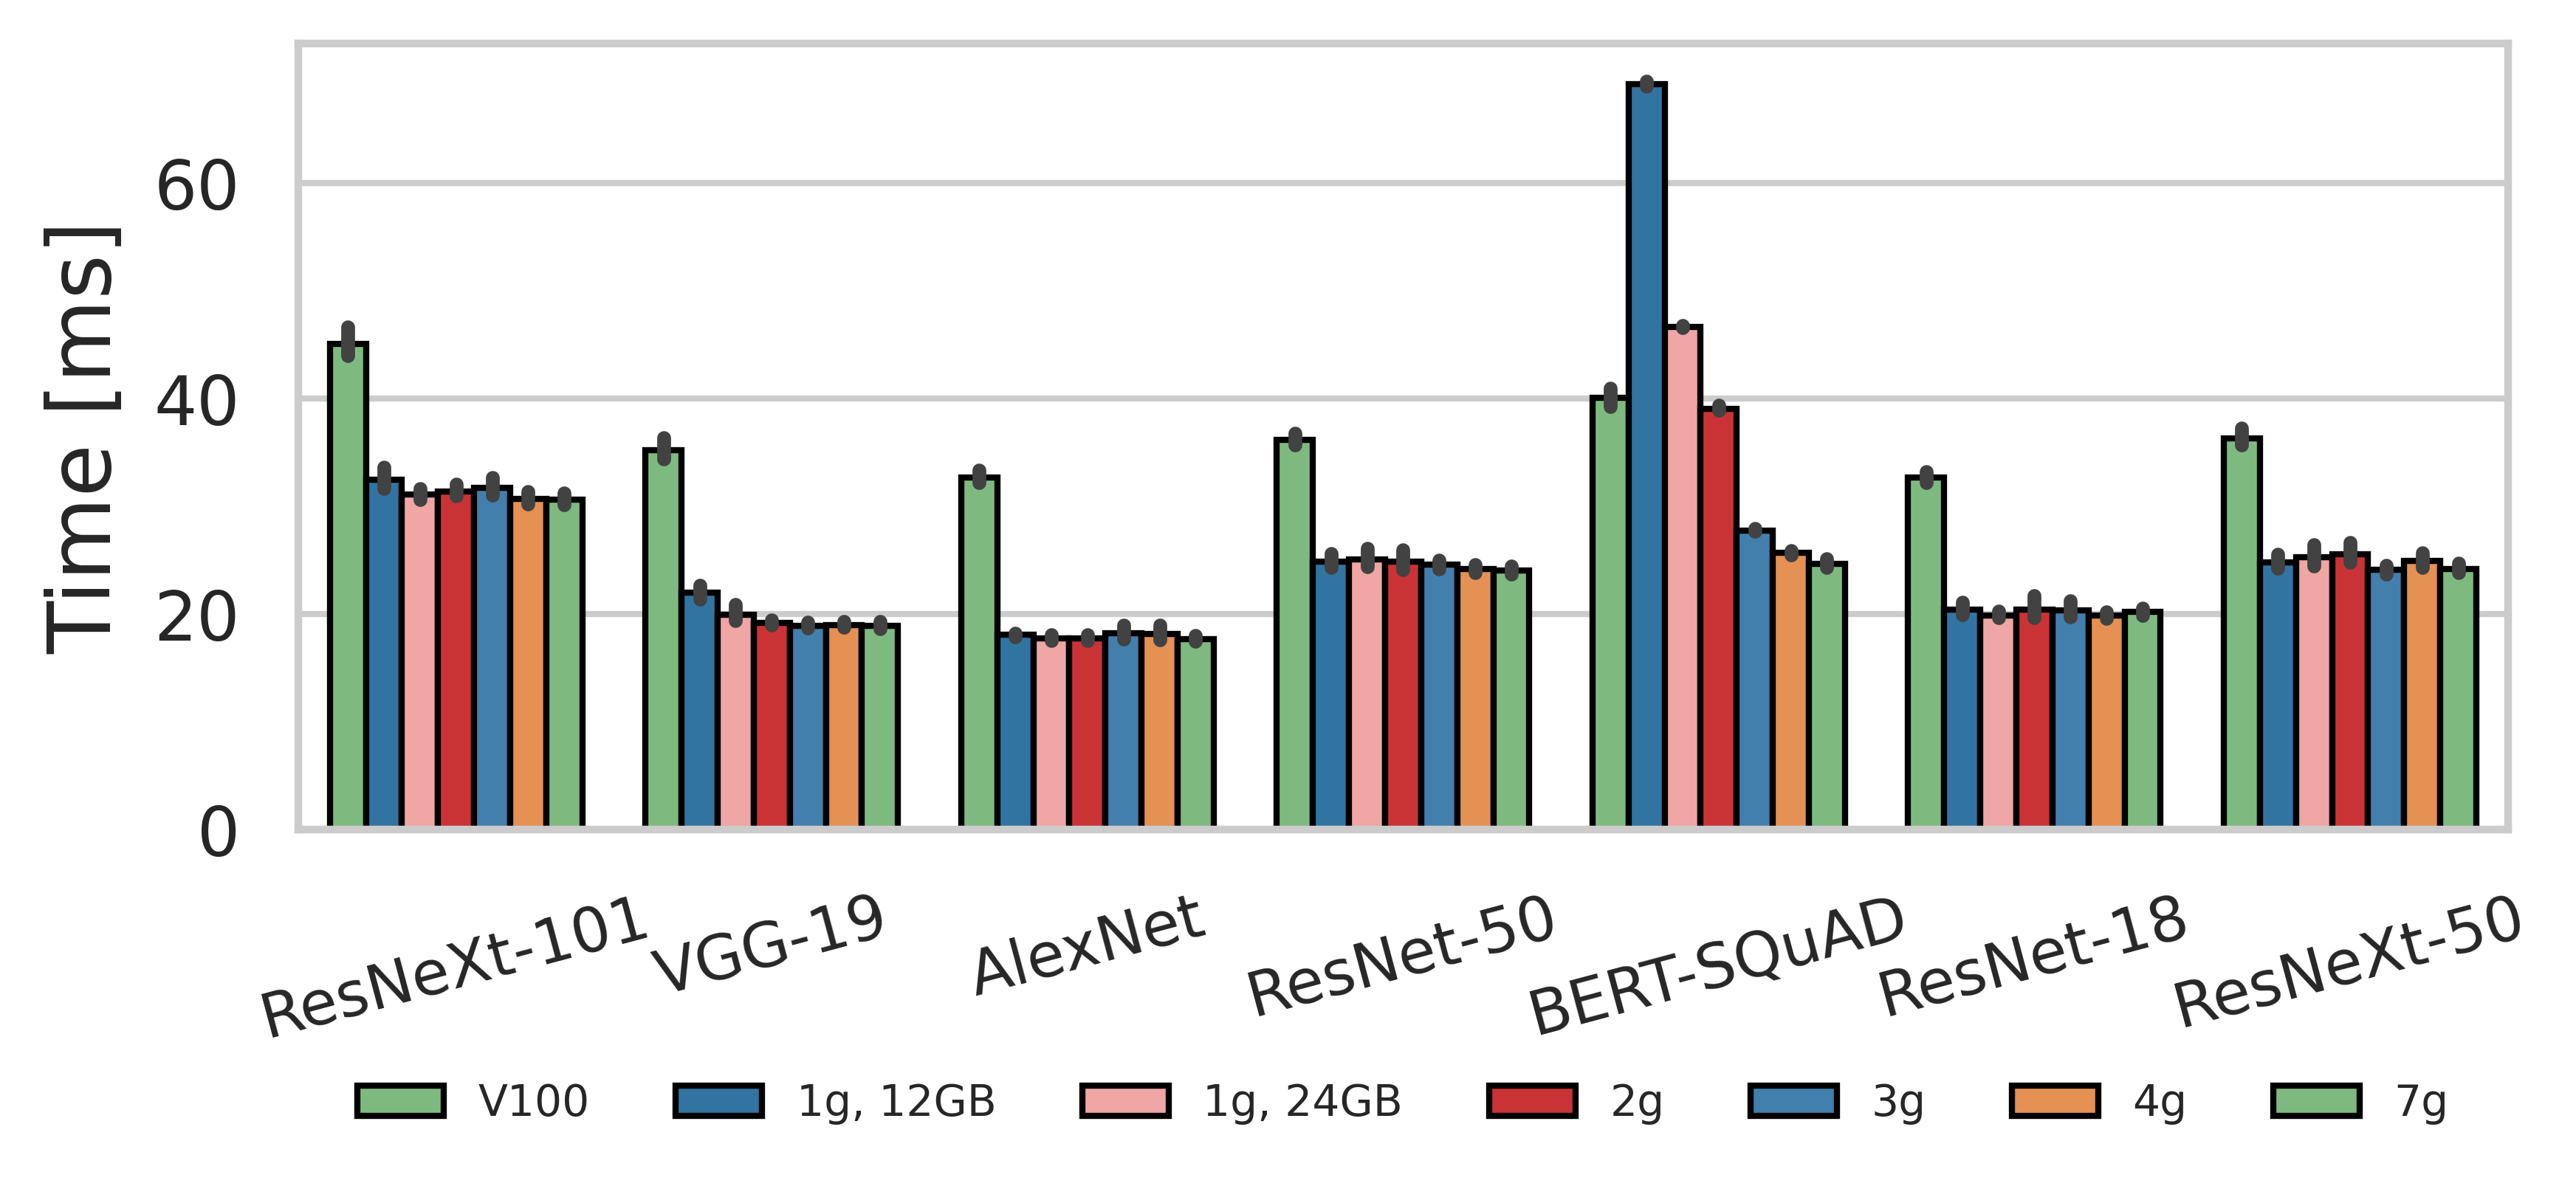

In [130]:
from itertools import cycle
#fig = plt.figure(figsize=(4,2))
#ax = fig.gca()

sns.set(rc={'figure.figsize':(6, 3)})
sns.set_style("whitegrid")

colors = ['#3182bd', '#fd8d3c', '#74c476', '#e6550d']

benchmark_colors = ['#74c476',  # light blue
                   '#1f78b4',   # darker blue
                   '#fb9a99',   # light red
                   '#e31a1c','#3182bd','#fd8d3c']   # darker red

hatches = cycle(['/', '\\', 'x', '+', '+', ''])

#g = sns.catplot(x='benchmark', y='time', hue='migsize', data=final_df, kind='bar') 
g = sns.barplot(x='benchmark', y='time', hue='migsize',
                hue_order=['V100', '1g, 12GB', '1g, 24GB', '2g', '3g', '4g', '7g'],
                data=df,
               palette=benchmark_colors) #, height=5, aspect=1)

#num_locations = 6
for i, patch in enumerate(g.patches):
    patch.set_edgecolor('black')
#    if i % num_locations == 0:
#        hatch = next(hatches)
#    patch.set_hatch(hatch)


#g = sns.lineplot(data=final_df.loc[final_df['migsize'] == 'small'], x='size', y='time', hue='benchmark')
#g.set_xlabel('Co-located NAS benchmarks - (NAS application, input size, MPI ranks).',fontsize=14)
#g.set_xlabel('Size [kB]',fontsize=14)

g.set_ylabel('Time [ms]',fontsize=14)
g.set_xlabel('')
#g.set_title('Slowdown of the batch job LULESH.',fontsize=16)
g.legend(title='MIG size', fontsize=11,title_fontsize=11, ncols=4,loc='upper right', bbox_to_anchor=(0.95, -0.15))
#plt.legend.set_title('LULESH problem size',prop={'fontsize':14})
#g.set_ylim([-4,6])
#g.axhline(y=0, color='black', linestyle='-')
#g.set_xlim([-0.5,5.5])
#g.set_xscale('log',base=2)
#g.set_xticks([0, 1024, 2048])
#g.set_xlim([0,1024])
plt.xticks(fontsize=10, rotation=15)

g.legend(bbox_to_anchor=(0.5, -0.3), 
         loc='upper center', 
         ncol=7,
         borderaxespad=0.,fontsize=7)

plt.tight_layout()
plt.savefig("migsize_new.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)


## BERT Scaling Efficiency

In [131]:
df.groupby(['benchmark', 'migsize']).mean()['time']

benchmark    migsize 
AlexNet      1g, 12GB    18.056113
             1g, 24GB    17.718603
             2g          17.735121
             3g          18.200768
             4g          18.142691
             7g          17.697118
             V100        32.683856
BERT-SQuAD   1g, 12GB    69.160878
             1g, 24GB    46.631544
             2g          39.057522
             3g          27.764748
             4g          25.648575
             7g          24.682783
             V100        40.091622
ResNeXt-101  1g, 12GB    32.459802
             1g, 24GB    31.085111
             2g          31.392338
             3g          31.683485
             4g          30.704841
             7g          30.582287
             V100        45.032735
ResNeXt-50   1g, 12GB    24.816559
             1g, 24GB    25.299518
             2g          25.540494
             3g          24.074157
             4g          24.957229
             7g          24.180663
             V100        36.26918

In [132]:
x = 69.160878 / df.loc[final_df['benchmark'] == 'BERT-SQuAD'].groupby(['migsize'])['time'].mean() 
x

migsize
1g, 12GB    1.000000
1g, 24GB    1.483135
2g          1.770744
3g          2.490960
4g          2.696480
7g          2.801989
V100        1.725071
Name: time, dtype: float64

In [133]:
x = 69.160878 / df.loc[df['benchmark'] == 'BERT-SQuAD'].groupby(['migsize'])['time'].mean() 
x / 7

migsize
1g, 12GB    0.142857
1g, 24GB    0.211876
2g          0.252963
3g          0.355851
4g          0.385211
7g          0.400284
V100        0.246439
Name: time, dtype: float64

# Utilization

In [72]:
import re
from pathlib import Path

def extract_timestamps(file_path):
    """
    Extract start timestamps from raw_output.txt file
    
    Args:
        file_path (str): Path to raw_output.txt
    
    Returns:
        list: List of timestamps
    """
    timestamps = []
    timestamp_pattern = re.compile(r'Start: (\d+),')
    
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('Start:'):
                match = timestamp_pattern.search(line)
                if match:
                    timestamps.append(int(match.group(1)))
    
    return timestamps

def process_benchmark_timestamps(base_dir):
    """
    Process all benchmark directories and extract timestamps
    
    Args:
        base_dir (str): Base directory containing benchmark subdirectories
    
    Returns:
        dict: Dictionary with benchmark names as keys and lists of timestamps as values
    """
    base_path = Path(base_dir)
    results = {}
    
    # Process each benchmark directory
    for bench_dir in base_path.iterdir():
        if not bench_dir.is_dir() or bench_dir.name == 'yolop':
            continue
            
        output_file = bench_dir / 'raw_output.txt'
        if output_file.exists():
            timestamps = extract_timestamps(str(output_file))
            results[bench_dir.name] = timestamps
    
    return results

def process_gpu_usage(file_path):
    """
    Process GPU usage data from the raw_usage.txt file
    
    Args:
        file_path (str): Path to the raw_usage.txt file
    
    Returns:
        pd.DataFrame: Processed GPU usage data
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    #print(df)
    # Convert time to relative timestamps (seconds from start)
    #df['relative_time'] = (df['time'] - df['time'].iloc[0]) / 1e9  # Convert nanoseconds to seconds
    
    # Calculate memory usage in GB
    df['memory_used_gb'] = df['memUsed'] / 1024  # Assuming memory is in MB
    df['memory_total_gb'] = df['memTotal'] / 1024
    df['memory_free_gb'] = df['memFree'] / 1024
    df['memory_reserved_gb'] = df['memReserved'] / 1024
    
    return df

base_dir = "../../data/mig_size_effect/mig-isolation-bench-v100-2025-02-07T02:34:51+01:00"
timestamps_by_benchmark = process_benchmark_timestamps(base_dir)

dfs = {}

base_path = Path(base_dir)
for bench_dir in base_path.iterdir():
    if not bench_dir.is_dir() or bench_dir.name == 'yolop':
        continue

    output_file = bench_dir / 'raw_usage.txt'
    if output_file.exists():
        df = process_gpu_usage(output_file)
        dfs[bench_dir.name] = df
    
for benchmark, timestamps in timestamps_by_benchmark.items():
    print(f"\n{benchmark}:")
    print(f"Number of timestamps: {len(timestamps)}")
    if timestamps:
        print(f"First timestamp: {timestamps[0]}")
        print(f"Last timestamp: {timestamps[-1]}")


resnext-101:
Number of timestamps: 11
First timestamp: 1738892127094989856
Last timestamp: 1738892128734330233

vgg19:
Number of timestamps: 11
First timestamp: 1738892138791013633
Last timestamp: 1738892140256659961

alexnet:
Number of timestamps: 11
First timestamp: 1738892094789437725
Last timestamp: 1738892096015161595

resnet-50:
Number of timestamps: 11
First timestamp: 1738892121409957488
Last timestamp: 1738892122669986368

BERT-SQuAD:
Number of timestamps: 11
First timestamp: 1738892099444522452
Last timestamp: 1738892111603354752

resnet-18:
Number of timestamps: 11
First timestamp: 1738892115966975810
Last timestamp: 1738892117082851481

resnext-50:
Number of timestamps: 11
First timestamp: 1738892133139417566
Last timestamp: 1738892134433001500


In [76]:
timestamps_by_benchmark['BERT-SQuAD']

[1738892099444522452,
 1738892111240958881,
 1738892111283026610,
 1738892111324461061,
 1738892111365773141,
 1738892111407054060,
 1738892111448255214,
 1738892111487511985,
 1738892111526253886,
 1738892111564821002,
 1738892111603354752]

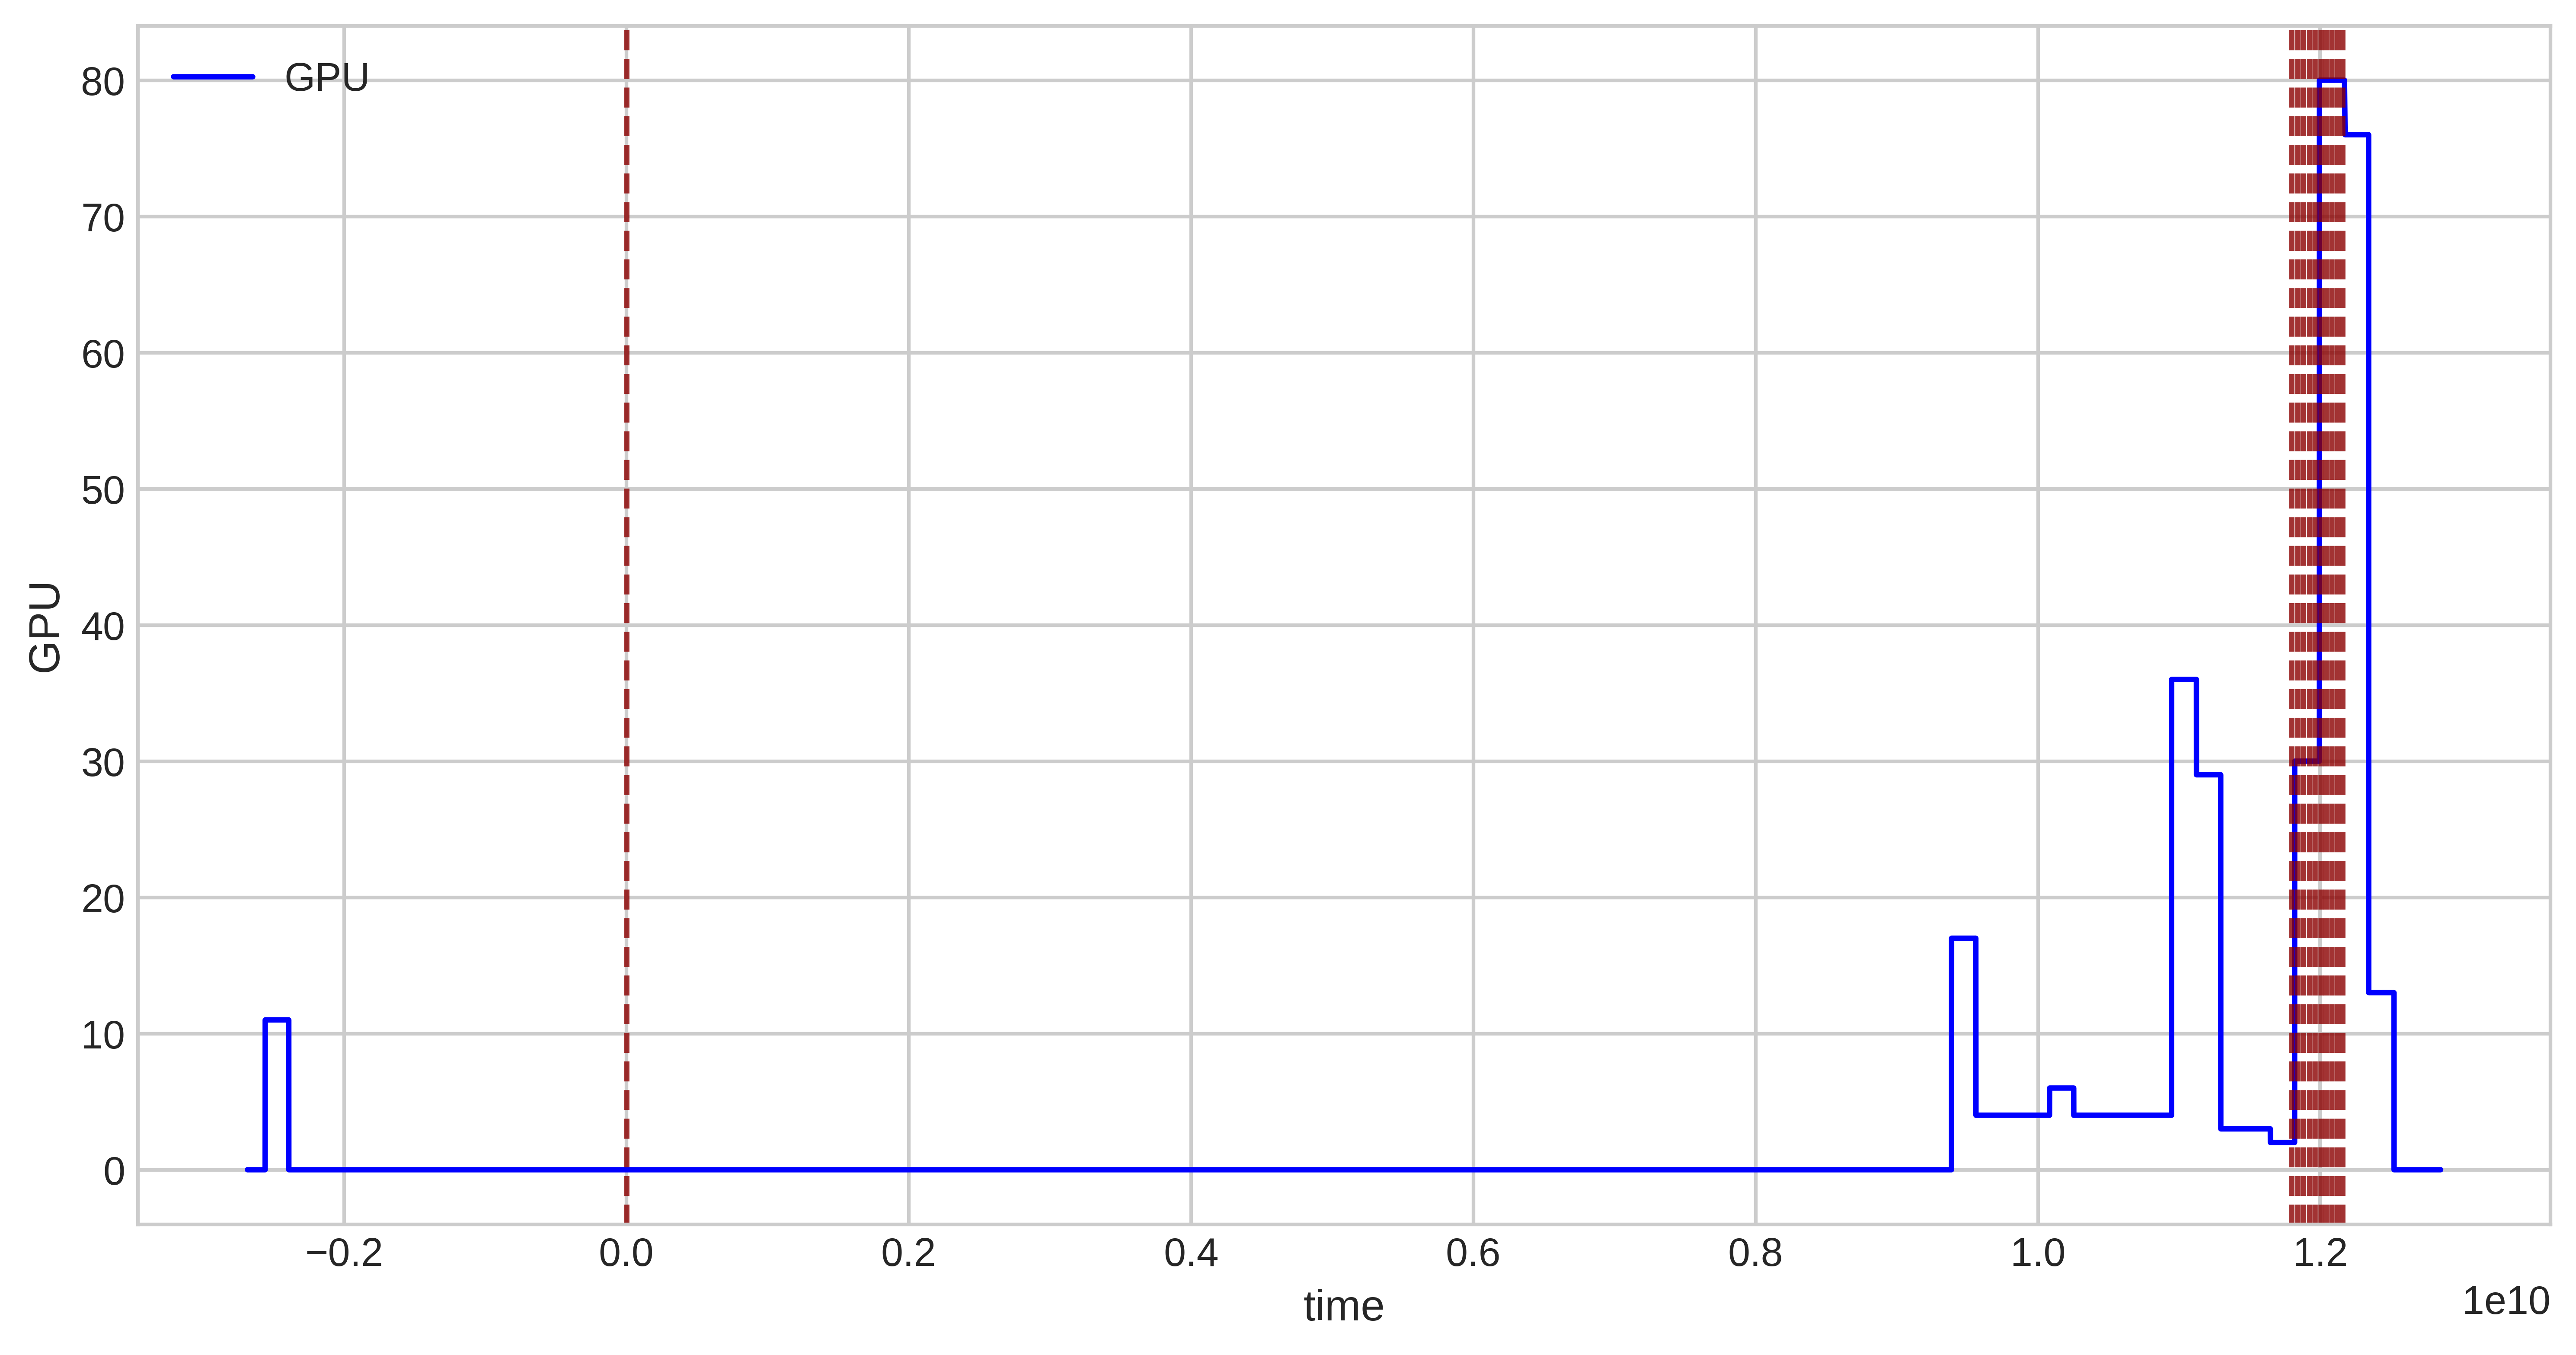

In [84]:

plt.style.use('seaborn-v0_8-whitegrid')

# Create figure with specified size
fig, ax1 = plt.subplots(figsize=(12, 6))

new_df = dfs['BERT-SQuAD'].copy()
new_df['time'] -= timestamps_by_benchmark['BERT-SQuAD'][0]

x_markers = [x - timestamps_by_benchmark['BERT-SQuAD'][0] for x in timestamps_by_benchmark['BERT-SQuAD']]

# Plot GPU memory usage
#sns.lineplot(data=dfs['resnet-50'], x='time', y='memory_used_gb',
#            color='blue', label='Memory Used', ax=ax1)
sns.lineplot(data=new_df, x='time', y='GPU',
            color='blue', label='GPU', ax=ax1)

for x_pos in x_markers:
    ax1.axvline(x=x_pos, color='darkred', linestyle='--',
               linewidth=1.5, alpha=0.8)

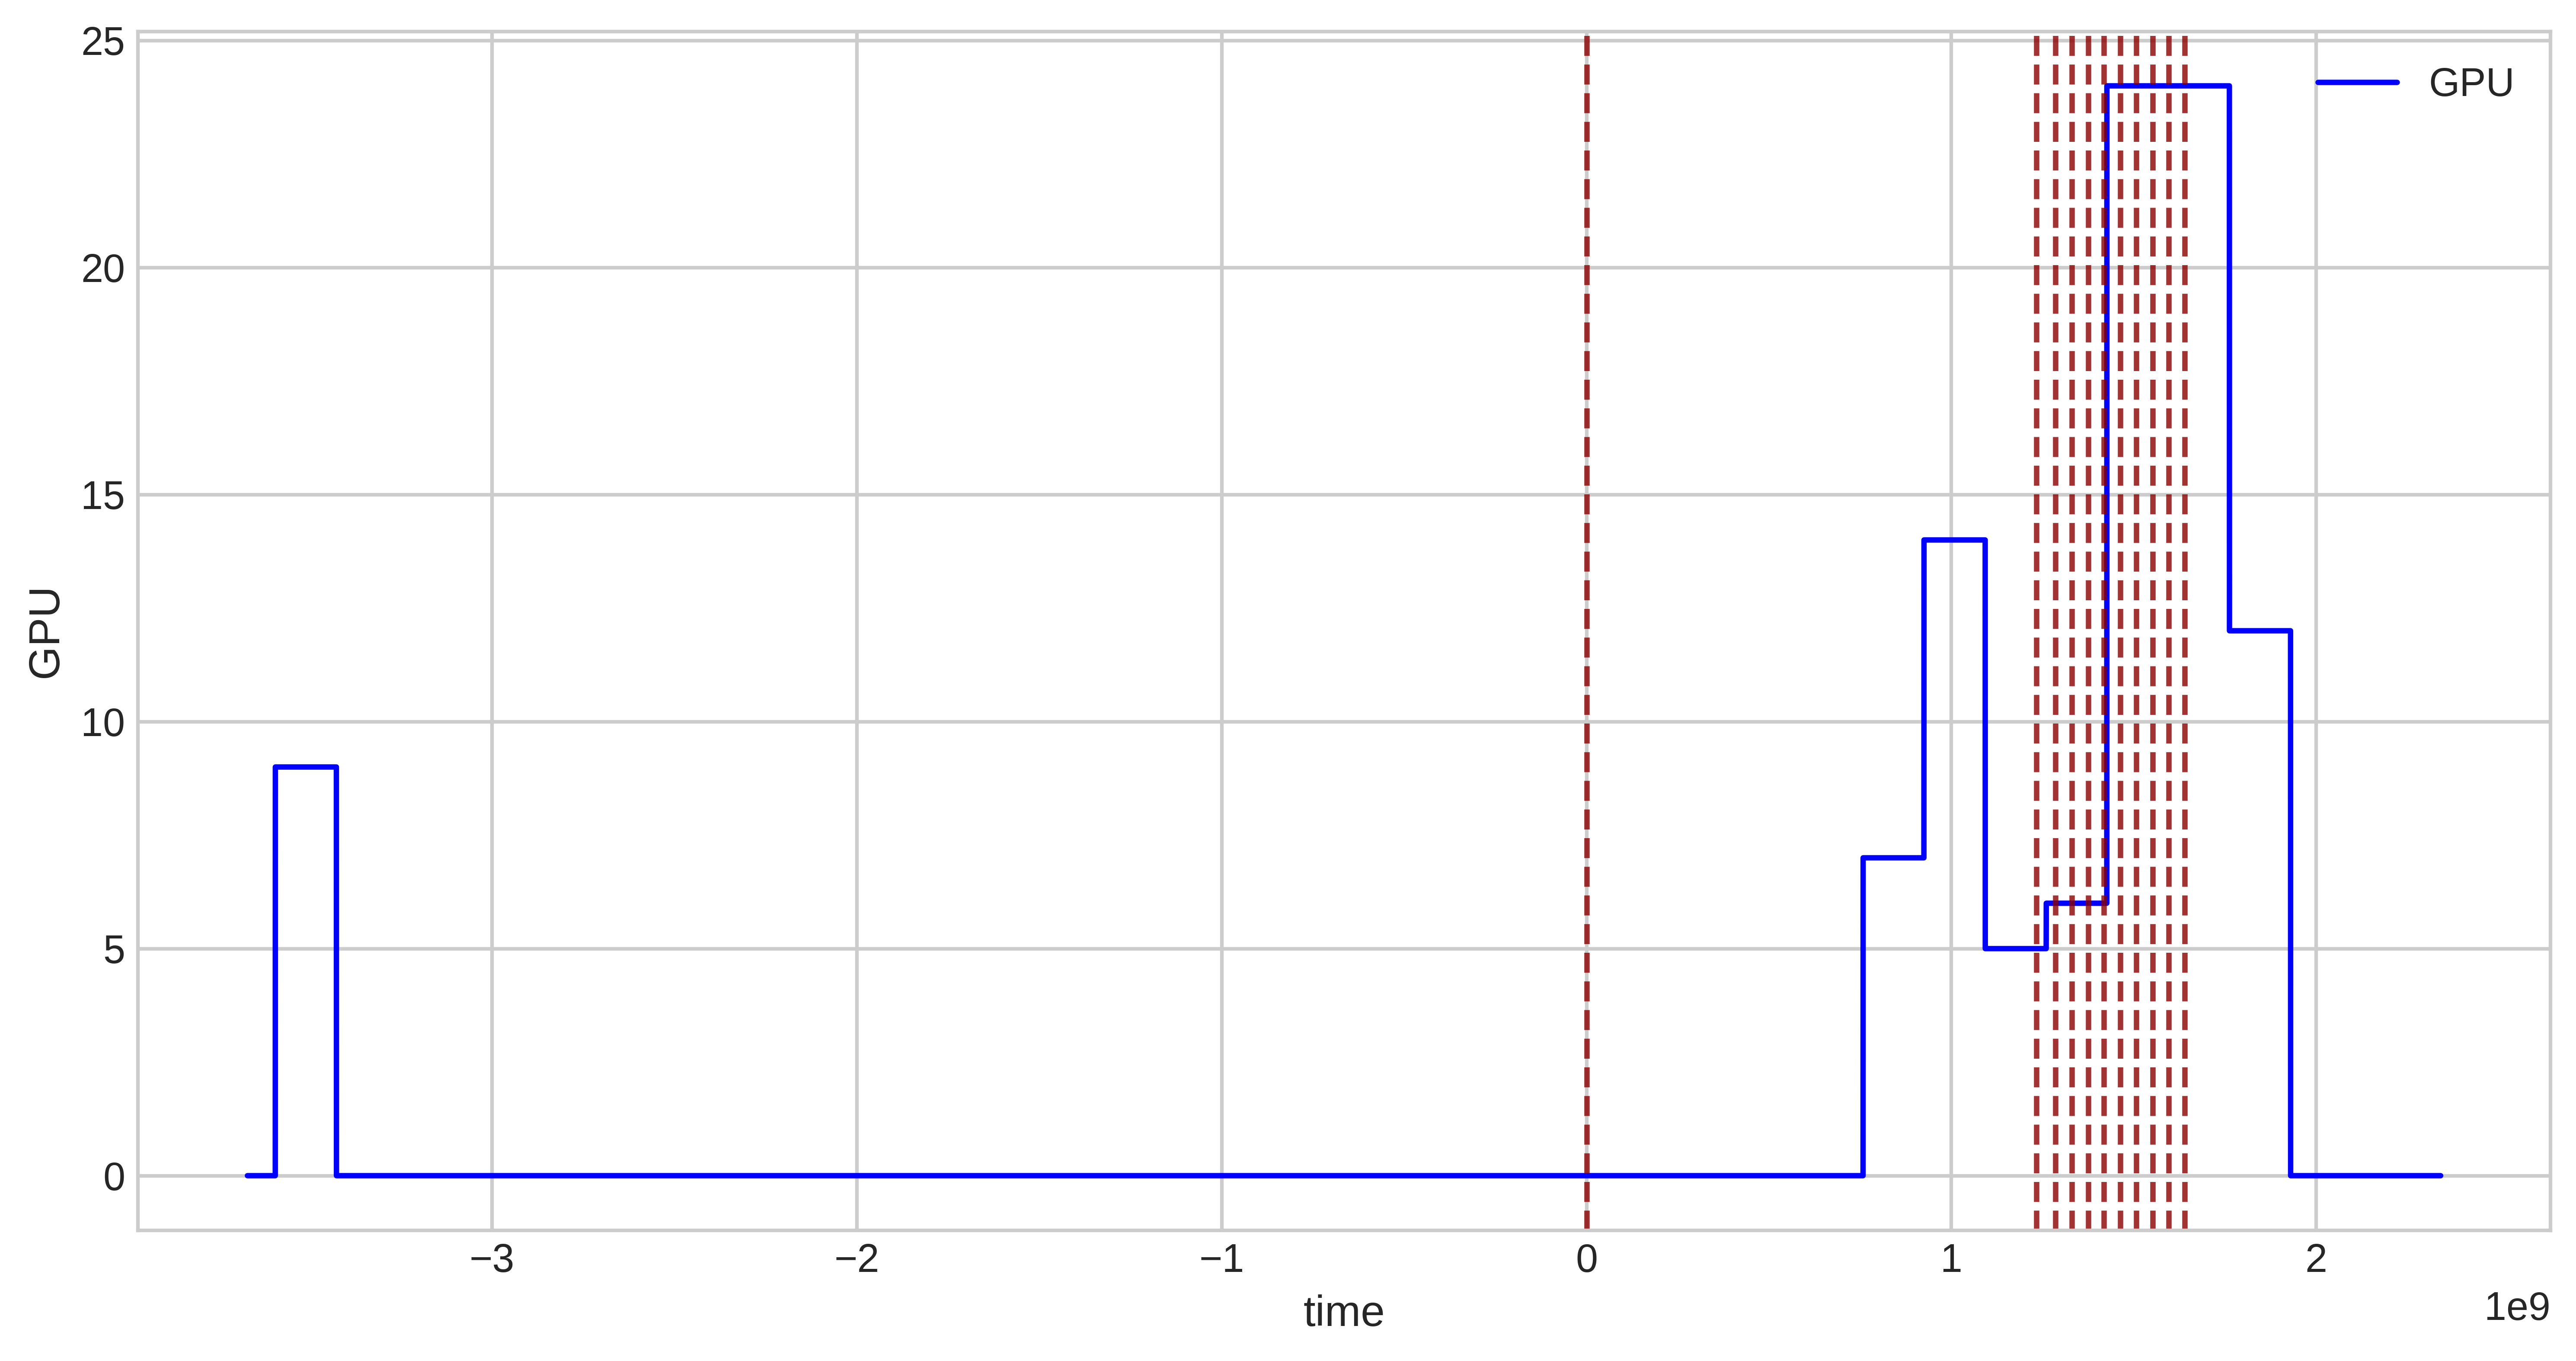

In [87]:

plt.style.use('seaborn-v0_8-whitegrid')

# Create figure with specified size
fig, ax1 = plt.subplots(figsize=(12, 6))

bench = 'resnext-101'

new_df = dfs[bench].copy()
new_df['time'] -= timestamps_by_benchmark[bench][0]

x_markers = [x - timestamps_by_benchmark[bench][0] for x in timestamps_by_benchmark[bench]]

# Plot GPU memory usage
#sns.lineplot(data=dfs['resnet-50'], x='time', y='memory_used_gb',
#            color='blue', label='Memory Used', ax=ax1)
sns.lineplot(data=new_df, x='time', y='GPU',
            color='blue', label='GPU', ax=ax1)

for x_pos in x_markers:
    ax1.axvline(x=x_pos, color='darkred', linestyle='--',
               linewidth=1.5, alpha=0.8)

### Statistics

In [165]:

results = []
for bench_name, df in dfs.items():
    # Calculate memory utilization percentage
    if 'memTotal' in df.columns and 'memUsed' in df.columns:
        max_mem_pct = round((df['memUsed'] / df['memTotal'] * 100).max(),2)
    else:
        max_mem_pct = None

    # Get SM utilization if available
    if 'GPU' in df.columns:
        max_sm_util = df['GPU'].max()
    else:
        max_sm_util = None

    results.append({
        'benchmark': bench_name,
        'max_memory_util_pct': max_mem_pct,
        'max_sm_util_pct': max_sm_util
    })

In [166]:
results

[{'benchmark': 'resnext-101',
  'max_memory_util_pct': 4.74,
  'max_sm_util_pct': 24},
 {'benchmark': 'vgg19', 'max_memory_util_pct': 6.16, 'max_sm_util_pct': 23},
 {'benchmark': 'alexnet', 'max_memory_util_pct': 3.94, 'max_sm_util_pct': 18},
 {'benchmark': 'resnet-50',
  'max_memory_util_pct': 3.34,
  'max_sm_util_pct': 8.0},
 {'benchmark': 'BERT-SQuAD',
  'max_memory_util_pct': 13.92,
  'max_sm_util_pct': 80},
 {'benchmark': 'resnet-18',
  'max_memory_util_pct': 2.91,
  'max_sm_util_pct': 38.0},
 {'benchmark': 'resnext-50',
  'max_memory_util_pct': 3.12,
  'max_sm_util_pct': 14.0}]

In [156]:

base_dir = "../../data/mig_size_effect/mig-isolation-bench-h200-2025-02-07T01:11:47+01:00"
timestamps_by_benchmark = process_benchmark_timestamps(base_dir)

new_dfs = {}

base_path = Path(base_dir)
for bench_dir in base_path.iterdir():
    if not bench_dir.is_dir() or bench_dir.name == 'yolop':
        continue

    output_file = bench_dir / 'raw_usage.txt'
    if output_file.exists():
        df = process_gpu_usage(output_file)
        new_dfs[bench_dir.name] = df

In [161]:

new_results = []
for bench_name, df in new_dfs.items():
    # Calculate memory utilization percentage
    if 'memTotal' in df.columns and 'memUsed' in df.columns:
        max_mem_pct = round((df['memUsed'] / df['memTotal'] * 100).max(),2)
    else:
        max_mem_pct = None

    # Get SM utilization if available
    if 'GPU' in df.columns:
        max_sm_util = df['GPU'].max()
    else:
        max_sm_util = None

    new_results.append({
        'benchmark': bench_name,
        'max_memory_util_pct': max_mem_pct,
        'max_sm_util_pct': max_sm_util
    })

In [167]:
new_results

[{'benchmark': 'resnext-101',
  'max_memory_util_pct': 1.18,
  'max_sm_util_pct': 11.0},
 {'benchmark': 'vgg19', 'max_memory_util_pct': 1.41, 'max_sm_util_pct': 11},
 {'benchmark': 'alexnet', 'max_memory_util_pct': 1.02, 'max_sm_util_pct': 5.0},
 {'benchmark': 'resnet-50',
  'max_memory_util_pct': 0.92,
  'max_sm_util_pct': 8.0},
 {'benchmark': 'BERT-SQuAD',
  'max_memory_util_pct': 2.12,
  'max_sm_util_pct': 44},
 {'benchmark': 'resnet-18',
  'max_memory_util_pct': 0.84,
  'max_sm_util_pct': 11},
 {'benchmark': 'resnext-50',
  'max_memory_util_pct': 0.9,
  'max_sm_util_pct': 11.0}]